In [3]:
# запускаем в colab или локально?
try:
    from google.colab import drive
    colab = True
except ImportError:
    colab = False

print(f"colab: {colab}")

colab: False


In [4]:
# установка необходимых пакетов в colab
if colab:
    !pip install rootutils -q
    !pip install torchinfo -q
    !pip install torchmetrics -q
    !pip install livelossplot -q

In [5]:
# монтирование google диска и установка
# рабочей директории в `computer-vision`

import os
from rootutils import setup_root

if colab:
    drive.mount("/content/drive", force_remount=True)
    os.chdir("drive/MyDrive/computer-vision")
    root = setup_root(".", indicator="homeworks", pythonpath=True)
else:
    root = setup_root(".", indicator="homeworks", pythonpath=True)

os.chdir(root)
print(f"working directory: {os.getcwd()}")


working directory: /Users/alex/computer-vision


In [6]:
# создание директории для данных

from pathlib import Path

if colab:
    DATA_DIR = Path("/content/data")
else:
    DATA_DIR = root / "data"

DATA_DIR.mkdir(exist_ok=True)

print(f"DATA_DIR: {DATA_DIR}")

DATA_DIR: /Users/alex/computer-vision/data


In [7]:
# настройка matplotlib

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format="retina"

plt.style.use("seaborn-v0_8-notebook")

### **Операция свертки. Сверточные нейронные сети**

***
#### **1. Свойство инвариантности нейронных сетей**

- Нейронная сеть называется **инвариантной** к преобразованию $\mathbf{t}[\mathbf{x}]$ изображения, если:
    $$
        \mathbf{f}\left[\mathbf{t}[\mathbf{x}]\right] = 
        \mathbf{f}[\mathbf{x}]
    $$
- Например, классификатор изображений должен быть инвариантен к сдвигу изображений.

<center>
    <figure>
        <img src="../figures/03/invariant.jpg" width="200px"/>
    </figure>
</center>

***
#### **2. Свойство ковариантности нейронных сетей**

- Нейронная сеть называется **ковариантной** к преобразованию $\mathbf{t}[\mathbf{x}]$ изображения, если:
    $$
        \mathbf{f}\left[\mathbf{t}[\mathbf{x}]\right] = 
        \mathbf{t}\left[\mathbf{f}[\mathbf{x}]\right]
    $$

- Например, сегментация изображений должна быть ковариантна к сдвигу изображений.

<center>
    <figure>
        <img src="../figures/03/covariant.jpg" width="400px"/>
    </figure>
</center>

***
#### **3. Свойства инвариантности полносвязных и сверточных сетей**

- Полносвязные нейронные сети не инварианты и не ковариантны к сдвигу изображений.

- Сверточные сети состоят из последовательности сверточных слоев, каждый из которых ковариантен для переноса. 

- Сверточные сети также обычно включают операции pooling, которые способствуют частичной инвариантности к переносу.

***
#### **4. Операции свертки**

- Рассмотрим на примерах операции одномерных и двумерных сверток.

- Строго говоря, то что мы будем обсуждать, это корреляция, а не свертка. 

- В машинном обучении общепринято корреляцию называть сверткой.

***
#### **5. Пример одномерной свертки**

- Рассмотрим одномерную свертку с характеристиками:

    - размер ядра свертки: size = 3

    - шаг свертки: stride = 1
    - расширение: dilation = 1
    - без дополнения нулями: no padding


<center>
    <figure>
        <img src="../figures/03/conv1d_1.jpg" width="400px"/>
    </figure>
</center>

- Формула для свертки:
    $$
        z_i = \omega_1 x_{i-1} + \omega_2 x_{i} + \omega_3 x_{i+1}
    $$
    где $\omega_1\,,  \omega_2\,, \omega_3$ - ядро свертки (веса свертки).

- Без дополнения нулями, размер выходного вектора будет меньше входного.
- Видно, что свертка - ковариантная относительно сдвига операция.


***
#### **6. Пример одномерной свертки**

- Рассмотрим одномерную свертку с характеристиками:

    - size = 3 (размер ядра свертки)

    - stride = 1 (шаг)
    - dilation = 1 (расширение)
    - zero padding (c дополнением нулями)

<center>
    <figure>
        <img src="../figures/03/conv1d_2.jpg" width="180px"/>
    </figure>
</center>

- Свертка обычно имеет нечетный размер $2p+1$ и входной вектор дополняется с двух концов $p$ нулями.

- С zero padding размер входного и выходного вектора совпадают.

***
#### **7. Еще примеры одномерных сверток**

<center>
    <figure>
        <img src="../figures/03/conv1d_3.jpg" width="800px"/>
    </figure>
</center>

- В расширенных свертках с dilation > 1, мы прореживаем вектор весов нулями, что позволит комбинировать информацию с больших участков, используя меньше весов.

***
#### **8. Размер выходного вектора**

- Размер выходного вектора $\mathbf{z}$ после свертки, примерно в stride раз меньше размера входного вектора $\mathbf{x}$:
    $$
        D_{o} = \left\lfloor\frac{D_{i} + 2p - k}{s}\right\rfloor
    $$
    где 
    - $D_{o}$ - размер $\mathbf{z}$

    - $D_{i}$ - размер $\mathbf{x}$
    - $k$ - размер ядра свертки
    - $s$ - шаг (stride) свертки
    - $p$ - число нулей с каждой стороны входного вектора

- Эти формулы можно распространить на произвольное количество измерений (в двумерных и трехмерных свертках), повторив их для каждого из измерений.

***
#### **9. Сверточный слой**

- С размером ядра 3, шагом 1 и расширением 1, $i$-й скрытый элемент $h_i$ сверточного слоя вычисляется как:
    $$
        h_i = a\left[\beta + \omega_1 x_{i-1} + \omega_2 x_{i} + \omega_3 x_{i+1}\right]
    $$
    где смещение $\beta$ и веса ядра $\omega_1$, $\omega_2$, $\omega_3$ - параметры, которые мы хотим обучить, 
    $a$ - функция активации.

- Это специальный случай полносвязного слоя, для которого:
$$
    h_i = a\left[\beta_i + \sum_{j=1}^D\omega_{ij}x_j\right]
$$

- В полносвязном слое намного больше параметров: для $D$ входов и $D$ скрытых элементов в полносвязном слое будет $D^2 + D$ параметров.

***
#### **10. Сравнение числа параметров в полносвязном и сверточном слое**

<center>
    <figure>
        <img src="../figures/03/weights.jpg" width="800px"/>
    </figure>
</center>

В примере на картинке:

- в полносвязном слое будет $6\cdot6+6=42$ параметра: $\mathbf{\Omega}\in\mathbf{R}^{6\times6}$, $\mathbf{\beta}\in\mathbf{R}^6$

- в сверточных слоях с ядром 3 и шагами 1 и 2 будет всего $3 + 1 = 4$ параметра: $\mathbf{\Omega}=(\omega_1,\omega_2,\omega_3)\in\mathbf{R}^{3}$, $\beta\in\mathbf{R}$

***
#### **11. Многоканальные сверточные слои**

- В общем случае, вход и все скрытые сверточные слои имеют по несколько каналов.

- Каждая свертка дает новый набор скрытых переменных, который называется **картой признаков** или **каналом**:

<center>
    <figure>
        <img src="../figures/03/channels_1.jpg" width="500px"/>
    </figure>
</center>

***
#### **12. Число параметров многоканального сверточного слоя**

- Если входной слой имеет $C_i$ каналов, в следующем слое $C_o$ каналов и ядро размера $K$, то будет:
  $$
    C_i \cdot C_o \cdot K \quad \text{- весов} 
  $$
  $$
    \text{и} \quad C_o \quad \text{- смещений} 
  $$

<center>
    <figure>
        <img src="../figures/03/channels_2.jpg" width="300px"/>
    </figure>
</center>

***
#### **13. Рецептивные поля**

<center>
    <figure>
        <img src="../figures/03/fields.jpg" width="600px"/>
    </figure>
</center>

- Рецептивное поле скрытого элемента - это входные элементы, влияющие на данный скрытый элемент.

- C увеличением числа скрытых слоев, рецептивные поля скрытых элементов увеличиваются.

***
#### **14. Влияние рецептивных полей на выделение признаков изображения**
<center>
    <figure>
        <img src="../figures/03/features.jpg" width="500px"/>
    </figure>
</center>

В случае сверточных нейронных сетей для изображений:

- Рецептивные поля увеличиваются для каждого следующего скрытого слоя.

- Это приводит к тому, что каждый следующий слой выучивает более высокоуровневые признаки на изображении.

***
#### **15. Детектор границ одномерного сигнала**

Рассмотрим пример, как с помощью одномерной свертки можно детектировать границы одномерного сигнала.

x.shape: torch.Size([12])


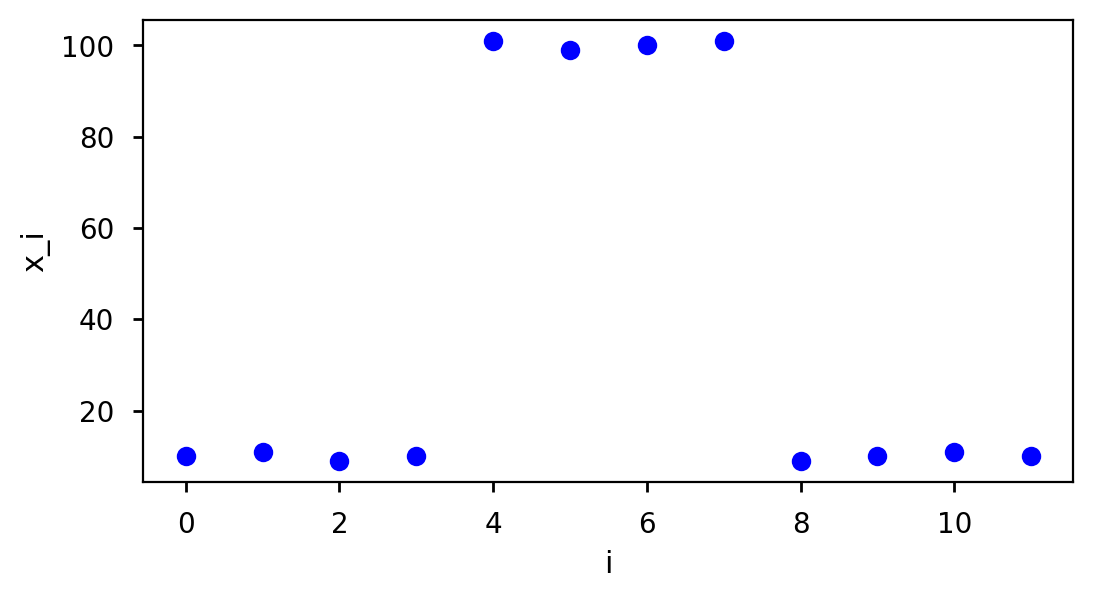

In [12]:
import torch

# одномерный тензор с двумя границами (скачками)
x = torch.tensor(
    [10, 11, 9, 10, 101, 99, 100, 101, 9, 10, 11, 10],
    dtype=torch.float32
)

print(f"x.shape: {x.shape}")

plt.figure(figsize=(6, 3))
plt.plot(x, "bo")
plt.xlabel("i")
plt.ylabel("x_i");

y.shape: torch.Size([1, 1, 11])


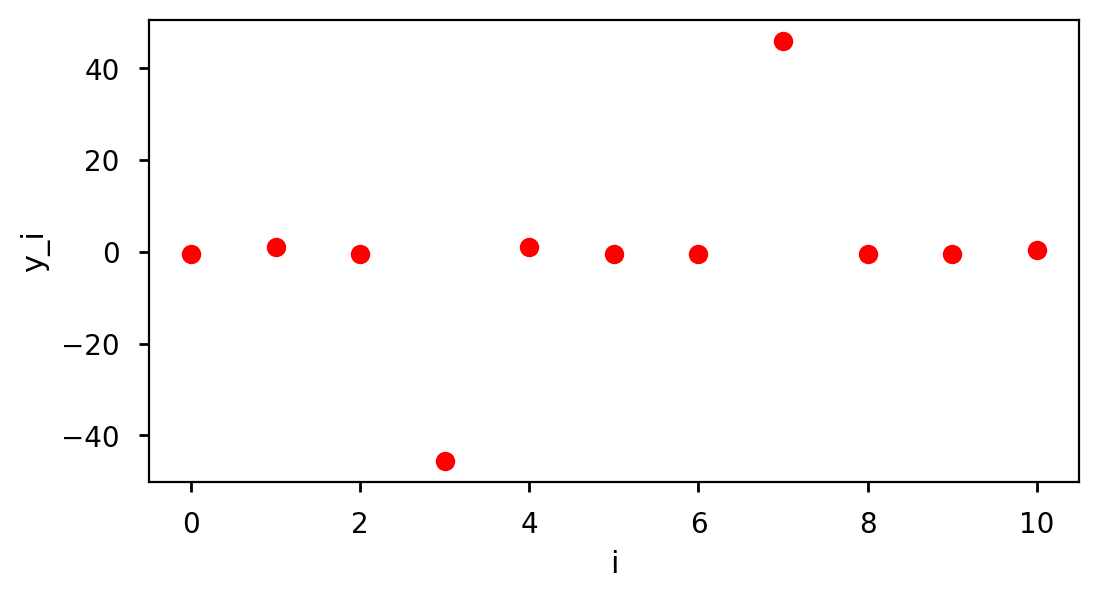

In [ ]:
# ядро свертки (вычисляет производную с помощью разностной схемы)
w = torch.tensor([0.5, -0.5])

# преобразование размера x
# к размеру [1 x 1 x 12]
# (batch size) x (num channels) x (len of x)
x = x.unsqueeze(0).unsqueeze(0) 

# преобразование размера w 
# к размеру [1 x 1 x 2]
w = w.unsqueeze(0).unsqueeze(0)

# операция 1D свертки
conv = torch.nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=0, dilation=1, bias=False)

# зададим веса свертки
conv.weight = torch.nn.Parameter(w, requires_grad=False) 

with torch.inference_mode():
    y = conv(x) 

print(f"y.shape: {y.shape}")

# преобразование размера [1 x 1 x 11] к [11]
y = y.flatten()

plt.figure(figsize=(6, 3))
plt.plot(y, "ro")
plt.xlabel("i")
plt.ylabel("y_i");

***
#### **16. Сверточный слой для одноканального (grayscale) изображения**

- Обычно сверточные слои используются для обработки двумерных изображений.

- В этом случае используются двумерные свертки.

<center>
    <figure>
        <img src="../figures/03/conv2d_1.jpg" width="800px"/>
    </figure>
</center>

- На картинке, каждый выход $h_{ij}$ вычисляет взвешенную сумму $3\times 3$ ближайших входов, добавляет смещение и пропускает результат через функцию активации:
$$
    h_{ij} = a\left[
        \beta + \sum_{m=1}^3\sum_{n=1}^3\omega_{mn}x_{i+m-2,\,j+n-2}
    \right]\,,\qquad
    \mathbf{\Omega}=\left\{\omega_{mn}\right\}\in\mathbf{R}^{3\times3}\,,
    \quad
    \beta\in\mathbf{R}
$$

***
#### **17. Padding**

С zero padding, как и в случае одномерной свертки, значения на позициях за кромкой изображения продолжаются нулями:

<center>
    <figure>
        <img src="../figures/03/conv2d_2.jpg" width="800px"/>
    </figure>
</center>

***
#### **18. Сверточный слой для RGB изображения**

RGB изображение обрабатывается как двумерный вход с тремя каналами, соответствующими красному, зеленому и синему цвету.

<center>
    <figure>
        <img src="../figures/03/conv2d_3.jpg" width="800px"/>
    </figure>
</center>

***
#### **19. Свертка многоканальных слоев**

- В общем случае входной и выходной слой имеют по несколько каналов.

- Если входной слой имеет $C_i$ каналов, в следующем слое $C_o$ каналов и ядро свертки размера $K\times K$, то у свертки будет:
$$
    C_i\cdot C_o\cdot K^2 \quad \text{- весов}
$$
$$
    \text{и} \quad C_o \quad \text{- смещений}
$$

***
#### **20. Изменение числа каналов**

Для того, чтобы изменить число каналов в слое, не меняя его пространственные размеры, применяют $1\times 1$ свертки: 

<center>
    <figure>
        <img src="../figures/03/conv2d_4.jpg" width="800px"/>
    </figure>
</center>

***
#### **21. Увеличение и уменьшение размера слоя (downsampling and upsampling)**
